In [1]:
import os
import cv2
import json
import argparse
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool

from utils.face_landmark import FaceAlignmentDetector
from utils.tool import draw_facial_landmarks
from utils.face_parsing import show_image

In [2]:
args_dict = {"json_file": './samples/meta_1-1.json'}

args = argparse.Namespace(**args_dict)

In [3]:
print(args)
# load json file
with open(args.json_file, 'r', encoding='utf8') as f:
    dtdict = json.load(f)


Namespace(json_file='./samples/meta_1-1.json')


In [4]:
save_folder = os.path.dirname(args.json_file)
head_image_folder = os.path.join(save_folder, 'head_images')
os.makedirs(head_image_folder, exist_ok=True)
head_parsing_folder = os.path.join(save_folder, 'head_parsing')
os.makedirs(head_parsing_folder, exist_ok=True)
align_image_folder = os.path.join(save_folder, 'align_images')
os.makedirs(align_image_folder, exist_ok=True)
align_parsing_folder = os.path.join(save_folder, 'align_parsing')
os.makedirs(align_parsing_folder, exist_ok=True)
print("head_image_folder:", head_image_folder)
print("head_parsing_folder:", head_parsing_folder)
print("align_image_folder:", align_image_folder)
print("align_parsing_folder:", align_parsing_folder)

head_image_folder: ./samples/head_images
head_parsing_folder: ./samples/head_parsing
align_image_folder: ./samples/align_images
align_parsing_folder: ./samples/align_parsing


In [5]:
dtdict.keys()

dict_keys(['images/000679.png', 'images/000031.png', 'images/man.jpg', 'images/woman.jpg', 'images/000320.png'])

563


  0%|          | 0/5 [00:00<?, ?it/s]

[-24.438751    -0.46229553 -17.837921  ]
[[ 0.91037442 -0.00734559  0.41372026]
 [ 0.13440952  0.95087333 -0.27887989]
 [-0.39134703  0.30949306  0.86663807]]
[[ 0.91037438 -0.00734558  0.41372024]
 [ 0.13440952  0.95087333 -0.2788799 ]
 [-0.39134702  0.30949308  0.86663808]]
[-24.438751220703125, -0.4622955024242401, -17.837923049926758]


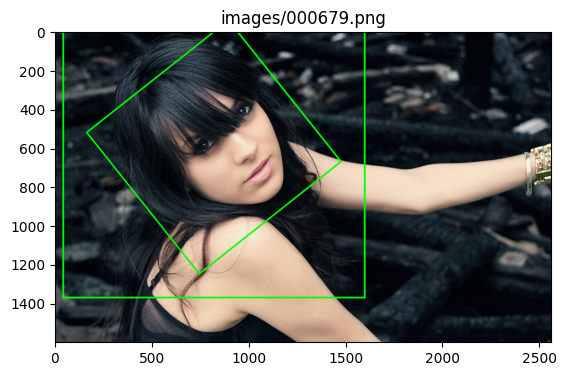

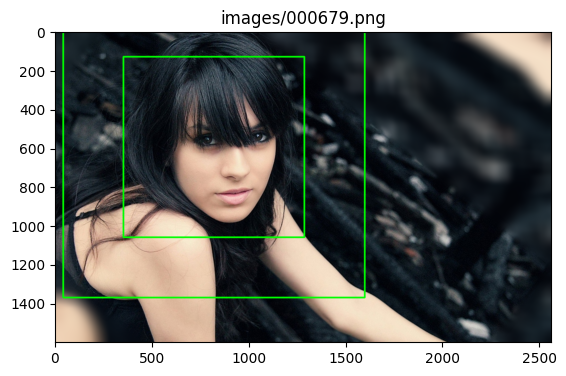

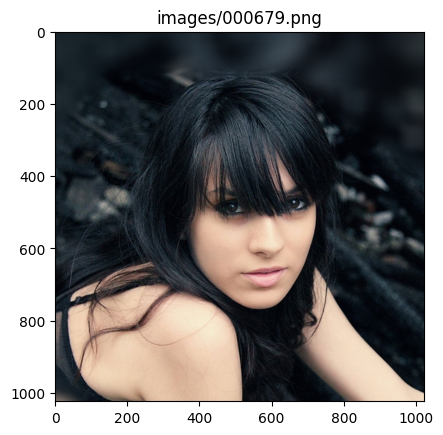

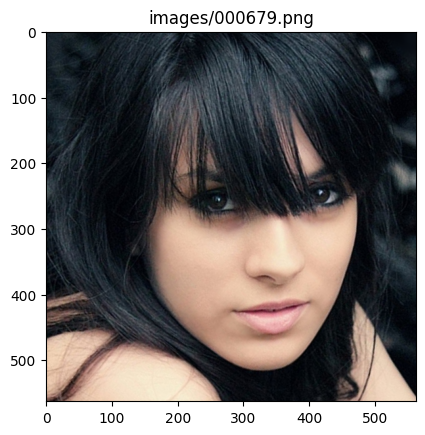

  0%|          | 0/5 [00:04<?, ?it/s]

images/000679.png
dict_keys(['data_source', 'raw', 'head'])


In [17]:
from utils.recrop_images import crop_final
from utils.face_parsing import HeadParser, show_result
from utils.fv_utils import generate_results, crop_head_image, crop_head_parsing
from utils.head_pose_estimation import WHENetHeadPoseEstimator
from utils.bv_utils import estimate_rotation_angle, rotate_image, rotate_quad
import utils.tool as mtool
import importlib
importlib.reload(mtool)
draw_quad = mtool.draw_quad
hpose2R = mtool.hpose2R
calculate_y_angle = mtool.calculate_y_angle
transform_box = mtool.transform_box
box2quad = mtool.box2quad
hpose2camera = mtool.hpose2camera
R2hpose = mtool.R2hpose

hpar = HeadParser()
pe = WHENetHeadPoseEstimator('assets/whenet_1x3x224x224_prepost.onnx')
assert pe.input_height == pe.input_width

scale = [0.6, 0.6]
shift = [0., 0.]
head_image_size = 1024

def get_final_crop_size(size, top_expand=0.1, left_expand=0.05, bottom_expand=0.0, right_expand=0.05):
    crop_w = int(size * (1 + left_expand + right_expand))
    crop_h = int(size * (1 + top_expand + bottom_expand))
    assert crop_w == crop_h
    return crop_w

crop_size = get_final_crop_size(512)
print(crop_size)

for dtkey, dtitem in tqdm(dtdict.items()):
    head_boxes = dtitem['raw']['head_boxes']
    # need_process = False
    # for box_id, box in head_boxes.items():
    #     if box_id not in dtdict[dtkey]['head'].keys():
    #         need_process = True
    #         break
    #     if dtdict[dtkey]['head'][box_id]['view'] is None:
    #         need_process = True
    #         break
    # if not need_process:
    #     continue

    if dtkey != 'images/000679.png': continue

    image_path = os.path.join(save_folder, dtitem['raw']['file_path'])
    image_name = os.path.basename(image_path)[:-4]
    image_data = cv2.imread(image_path)
    for box_id, box in head_boxes.items():
        if box_id in dtdict[dtkey]['head'].keys():
            if dtdict[dtkey]['head'][box_id]['view'] is not None:
                continue
        dtdict[dtkey]['raw']['landmarks'][box_id] = None

        box_np = np.array(box)
        rot_quad = box2quad(transform_box(box, scale, shift))
        rot_angle, rot_center = estimate_rotation_angle(image_data.copy(), box_np, pe, iterations=3)
        rotated_image, rotmat = rotate_image(image_data.copy(), rot_center, rot_angle)
        dtdict[dtkey]['raw']['rotmat'][box_id] = rotmat.tolist()
        dtdict[dtkey]['raw']['rot_quad'][box_id] = rot_quad.tolist()

        quad = rotate_quad(rot_quad, rot_center, -rot_angle)
        cropped_img, _, tf_quad = crop_final(image_data.copy(), size=crop_size, quad=quad, top_expand=0., left_expand=0., bottom_expand=0., right_expand=0.)
        dtdict[dtkey]['raw']['raw_quad'][box_id] = quad.tolist()
        dtdict[dtkey]['raw']['tgt_quad'][box_id] = tf_quad.tolist()

        head_image, head_crop_box, head_rot_quad = generate_results(rotated_image, rot_quad, box_np, head_image_size)
        dtdict[dtkey]['head'][box_id]['align_box'] = head_crop_box.tolist() # [x1, y1, w, h]
        dtdict[dtkey]['head'][box_id]['align_quad'] = head_rot_quad.tolist() # [tl, bl, br, tr]

        hpose = pe(head_image, isBGR=True)
        dtdict[dtkey]['head'][box_id]['hpose'] = hpose # yaw, roll, pitch
        camera_poses = hpose2camera(hpose)
        dtdict[dtkey]['head'][box_id]['camera'] = camera_poses.tolist()

        quad_w = np.linalg.norm(quad[2] - quad[1])
        quad_h = np.linalg.norm(quad[1] - quad[0])
        quad_center = np.mean(quad, axis=0)
        hbox_w = box_np[2]
        hbox_h = box_np[3]
        hbox_center = box_np[:2] + box_np[2:] / 2.
        dtdict[dtkey]['raw']['q2b_tf'][box_id] = {
            'scale': [quad_w / hbox_w, quad_h / hbox_h],
            'shift': [(quad_center[0] - hbox_center[0]) / hbox_w, (quad_center[1] - hbox_center[1]) / hbox_h]
        }

        head_parsing = hpar(head_image, is_bgr=True, show=False)
        cropped_par = crop_head_parsing(head_parsing.copy(), head_crop_box)
        cropped_par = cv2.resize(cropped_par, (cropped_img.shape[1], cropped_img.shape[0]), interpolation=cv2.INTER_NEAREST)

        head_image_path = os.path.join(head_image_folder, f"{image_name}_{box_id}.png")
        cv2.imwrite(head_image_path, head_image)
        head_parsing_path = os.path.join(head_parsing_folder, f"{image_name}_{box_id}.png")
        cv2.imwrite(head_parsing_path, head_parsing)

        align_image_path = os.path.join(align_image_folder, f"{image_name}_{box_id}.png")
        cv2.imwrite(align_image_path, cropped_img)
        align_parsing_path = os.path.join(align_parsing_folder, f"{image_name}_{box_id}.png")
        cv2.imwrite(align_parsing_path, cropped_par)

        # vis = draw_quad(image_data.copy(), box2quad(box_np).astype(np.int32))
        # vis = draw_quad(vis, quad.astype(np.int32))
        # show_image(vis, is_bgr=True, title=dtkey, show_axis=True)
        # 
        # vis = draw_quad(rotated_image.copy(), box2quad(box_np).astype(np.int32))
        # vis = draw_quad(vis, rot_quad.astype(np.int32))
        # show_image(vis, is_bgr=True, title=dtkey, show_axis=True)
        # 
        # show_image(head_image, is_bgr=True, title=dtkey, show_axis=True)
        # show_image(cropped_img, is_bgr=True, title=dtkey, show_axis=True)

        # head_image = crop_head_image(image_data.copy(), box_np)
        # assert head_image.shape[0] == head_image.shape[1]

        # print(angle)
        # show_image(rot_head_img, is_bgr=True, title=dtkey+f"_{i}", show_axis=True)
    print(dtkey)
    print(dtitem.keys())
    break

In [16]:
R2hpose(hpose2R([-23.687653, -1.1457214, -18.454369]))

[-23.687652587890625, -1.145721435546875, -18.454368591308594]

In [9]:
quad

array([[ 165.3666  ,  506.65326 ],
       [ 731.65326 , 1246.6335  ],
       [1471.6335  ,  680.3468  ],
       [ 905.34674 ,  -59.633423]], dtype=float32)